<a href="https://colab.research.google.com/github/pimanzi/art-classification-project/blob/main/Summative_Intro_to_ml_Placide_Imanzi_Kabisa_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and Error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency..

A Notebook detailing the following

* Project name
* Clear out puts from cells






**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo




# Case Study and Implementation




In [1]:
# Standard Libraries
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import joblib
from scipy.stats import randint

# Kagglehub (
import kagglehub

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Dropout, GlobalAveragePooling2D,
    RandomFlip, RandomRotation, RandomZoom,
    RandomContrast, RandomTranslation,RandomBrightness
)
from tensorflow.keras.applications import  EfficientNetB0, ResNet50
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# The Dataset
> ***Brief Description:***  
  Problem Statement:
  The aim of this project is to classify artworks based on their visual characteristics into various art styles or movements, such as Impressionism, Realism, and Cubism. This supports better digital organization, automatic tagging, and cultural heritage preservation.

  Dataset Description:
  We use the WikiArt - Art Movements/Styles dataset (https://www.kaggle.com/datasets/sivarazadi/wikiart-art-movementsstyles), which contains thousands of paintings labeled according to their artistic styles.

  In this project, I processed the raw image files myself, converting each image into a numerical array format suitable for machine learning. This involved resizing the images, normalizing pixel values, and transforming them into structured input data for model training. These extracted features serve as the foundation for training classification models capable of predicting the style of a given artwork based on its visual content.


In [2]:
# Download dataset
folders_path = kagglehub.dataset_download("sivarazadi/wikiart-art-movementsstyles")
print("folders downloaded to:", folders_path)


folders downloaded to: /kaggle/input/wikiart-art-movementsstyles


Displaying classes that my models will be predicting

In [3]:
path = "/kaggle/input/wikiart-art-movementsstyles"

# List all files in the directory
for file in os.listdir(path):
    print(file)


Academic_Art
Western_Medieval
Symbolism
Neoclassicism
Renaissance
Rococo
Japanese_Art
Art_Nouveau
Baroque
Expressionism
Romanticism
Primitivism
Realism


Processing my images and labelling them accordingly for classical machine learning model

In [5]:
def load_wikiart_images(
    base_path,
    image_size=(128, 128),
    flatten=True,
    max_images_per_class=500
):
    X = []
    y = []

    print("📦 Loading images...")

    for label, folder in enumerate(sorted(os.listdir(base_path))):
        outer_folder_path = os.path.join(base_path, folder)
        if not os.path.isdir(outer_folder_path):
            continue

        inner_folders = os.listdir(outer_folder_path)
        for inner_folder in inner_folders:
            inner_folder_path = os.path.join(outer_folder_path, inner_folder)
            if not os.path.isdir(inner_folder_path):
                continue

            image_count = 0

            for file in tqdm(os.listdir(inner_folder_path), desc=f"{folder}"):
                if image_count >= max_images_per_class:
                    break

                file_path = os.path.join(inner_folder_path, file)
                try:
                    img = Image.open(file_path).convert("RGB")
                    img = img.resize(image_size)
                    img_array = np.array(img)

                    if flatten:
                        img_array = img_array.flatten()

                    X.append(img_array)
                    y.append(label)
                    image_count += 1

                except Exception as e:
                    print(f"⚠️ Error loading {file_path}: {e}")

    X = np.array(X)
    y = np.array(y)

    return X, y


In [9]:

X, y = load_wikiart_images(path, flatten=True)
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


📦 Loading images...


Western_Medieval:  43%|████▎     | 500/1158 [00:58<01:16,  8.55it/s]


Shape of X: (6500, 49152)
Shape of y: (6500,)


Splitting my data  for classical machine learning for classical machine learning model

In [ ]:

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)
print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: (4550, 49152) (4550,)
Validation set: (975, 49152) (975,)
Test set: (975, 49152) (975,)


# SECTION 0: IMPLEMENTING CLASSICAL MACHINE LEARNING(Random Forest)

In [ ]:
os.makedirs('saved_models', exist_ok=True)

X_train_small, _, y_train_small, _ = train_test_split(
    X_train, y_train, train_size=0.3, stratify=y_train, random_state=42
)

pipe_rf = Pipeline([
    ('pca', PCA()),
    ('clf', RandomForestClassifier(random_state=42))
])


param_dist_rf = {
    'pca__n_components': [50, 100, 150],
    'clf__n_estimators': randint(50, 150),
    'clf__max_depth': [10, 20, None],
    'clf__min_samples_split': [2, 5],
    'clf__max_features': ['sqrt', 'log2']
}

# Randomized search
random_search_rf = RandomizedSearchCV(
    estimator=pipe_rf,
    param_distributions=param_dist_rf,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

print("🔍 Fast hyperparameter tuning with PCA + RandomizedSearchCV...")
random_search_rf.fit(X_train_small, y_train_small)

# Best model
best_rf_model = random_search_rf.best_estimator_
print("✅ Best RF Hyperparameters (with PCA):", random_search_rf.best_params_)

# Evaluate on validation set
y_val_pred_rf = best_rf_model.predict(X_val)
print("\n📊 RF Evaluation on Validation Set:")
print("Accuracy:", accuracy_score(y_val, y_val_pred_rf))
print("Precision (macro):", precision_score(y_val, y_val_pred_rf, average='macro'))
print("Recall (macro):", recall_score(y_val, y_val_pred_rf, average='macro'))
print("F1 Score (macro):", f1_score(y_val, y_val_pred_rf, average='macro'))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred_rf))

# Save the model
model_path_rf = 'saved_models/tuned_random_forest_pca_model.joblib'
joblib.dump(best_rf_model, model_path_rf)
print(f"💾 Best RF model with PCA saved to: {model_path_rf}")

🔍 Fast hyperparameter tuning with PCA + RandomizedSearchCV...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Best RF Hyperparameters (with PCA): {'clf__max_depth': 20, 'clf__max_features': 'sqrt', 'clf__min_samples_split': 5, 'clf__n_estimators': 137, 'pca__n_components': 100}

📊 RF Evaluation on Validation Set:
Accuracy: 0.23794871794871794
Precision (macro): 0.24046705709141417
Recall (macro): 0.23794871794871794
F1 Score (macro): 0.23149112175753117

Classification Report:
               precision    recall  f1-score   support

           0       0.15      0.13      0.14        75
           1       0.31      0.35      0.33        75
           2       0.18      0.23      0.20        75
           3       0.23      0.13      0.17        75
           4       0.32      0.39      0.35        75
           5       0.47      0.43      0.45        75
           6       0.32      0.15      0.20        75
           7       0.16      0.21      0.18        75
           8   

#SECTION 1: Model Architecture:

<img src="https://drive.google.com/uc?export=view&id=1qpgfUO2essix33_3cAkM66mcVx83cyqN" alt="Model Architecture">







#Task: Define a function that creates models without and With specified Optimization techniques


Processing images and labelling them accordingly for Neural Network model

In [6]:
# Load fewer images for testing (200–300/class)
X, y = load_wikiart_images(path, image_size=(224, 224), flatten=False, max_images_per_class=500)

# Use float32 early
X = np.array(X).astype('float32')

# Split before preprocessing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Free memory
del X_temp, y_temp
del X

# Now preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input
X_train = preprocess_input(X_train.astype('float32'))
X_val = preprocess_input(X_val.astype('float32'))
X_test = preprocess_input(X_test.astype('float32'))
print(X_train)
print(X_val)
print(X_test)


📦 Loading images...


Western_Medieval:  43%|████▎     | 500/1158 [00:56<01:14,  8.84it/s]


[[[[176. 185. 176.]
   [177. 185. 178.]
   [186. 193. 188.]
   ...
   [ 60.  78.  59.]
   [ 55.  76.  54.]
   [ 64.  86.  59.]]

  [[176. 185. 180.]
   [179. 188. 184.]
   [186. 195. 192.]
   ...
   [ 64.  83.  65.]
   [ 58.  78.  60.]
   [ 64.  83.  62.]]

  [[174. 183. 184.]
   [183. 193. 193.]
   [172. 182. 182.]
   ...
   [ 63.  84.  69.]
   [ 63.  82.  67.]
   [ 66.  84.  65.]]

  ...

  [[156. 166. 107.]
   [153. 158.  97.]
   [161. 162. 102.]
   ...
   [162. 173. 143.]
   [155. 166. 135.]
   [148. 159. 127.]]

  [[152. 162.  96.]
   [164. 169. 102.]
   [172. 171. 108.]
   ...
   [163. 173. 144.]
   [158. 169. 136.]
   [153. 164. 129.]]

  [[145. 149.  78.]
   [151. 156.  89.]
   [160. 162. 100.]
   ...
   [155. 165. 139.]
   [155. 165. 136.]
   [156. 167. 137.]]]


 [[[ 40.  35.  36.]
   [ 36.  34.  35.]
   [ 34.  36.  35.]
   ...
   [ 35.  35.  35.]
   [ 35.  35.  37.]
   [ 34.  34.  36.]]

  [[  3.   0.   0.]
   [  0.   0.   0.]
   [  0.   0.   0.]
   ...
   [  0.   0.   0.]
 

In [7]:
def define_model(
    optimizer_name="adam",
    learning_rate=None,
    regularizer=None,
    reg_strength=0.001,
    dropout_rate=0.5,
    use_early_stopping=False,
    epochs=15,
    batch_size=8,
):
    print(f"\n🔧 Starting new training with EfficientNetB0 base (input: 224x224)...")

    # Choose optimizer
    if learning_rate:
        if optimizer_name.lower() == "adam":
            optimizer = Adam(learning_rate=learning_rate)
        elif optimizer_name.lower() == "rmsprop":
            optimizer = RMSprop(learning_rate=learning_rate)
        else:
            raise ValueError("Unsupported optimizer")
    else:
        optimizer = Adam() if optimizer_name.lower() == "adam" else RMSprop()

    # Set regularizer
    if regularizer == "l1":
        reg = l1(reg_strength)
    elif regularizer == "l2":
        reg = l2(reg_strength)
    else:
        reg = None

    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.15),
        RandomZoom(0.2),
        RandomContrast(0.1),
        RandomBrightness(0.2),
    ])

    # Load base model
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    base_model.trainable = True

    # Unfreeze only top layers
    fine_tune_at = 200  # EfficientNetB0 has 237 layers
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # Build model
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu', kernel_regularizer=reg)(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(13, activation='softmax')(x)

    model = Model(inputs, outputs)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    callbacks = []
    if use_early_stopping:
        callbacks.append(EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True))

    # Training
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )

    # Plotting
    plt.figure(figsize=(12, 4))
    plt.suptitle("📊 Training Curves")

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Loss Curve")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title("Accuracy Curve")
    plt.legend()
    plt.show()

    # Evaluation
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    acc = accuracy_score(y_test, y_pred_classes)
    prec = precision_score(y_test, y_pred_classes, average='macro')
    rec = recall_score(y_test, y_pred_classes, average='macro')
    f1 = f1_score(y_test, y_pred_classes, average='macro')

    print("\n🧪 Test Evaluation:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    return {
        "model": model,
        "history": history,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1
    }



🔧 Starting new training with EfficientNetB0 base (input: 224x224)...
Epoch 1/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 539s 908ms/step - accuracy: 0.2504 - loss: 2.2565 - val_accuracy: 0.4656 - val_loss: 1.6492
Epoch 2/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 519s 912ms/step - accuracy: 0.4180 - loss: 1.8117 - val_accuracy: 0.5118 - val_loss: 1.5609
Epoch 3/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 514s 905ms/step - accuracy: 0.4776 - loss: 1.6177 - val_accuracy: 0.5292 - val_loss: 1.4644
Epoch 4/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 563s 906ms/step - accuracy: 0.4943 - loss: 1.5464 - val_accuracy: 0.5374 - val_loss: 1.5477
Epoch 5/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 553s 890ms/step - accuracy: 0.5370 - loss: 1.4151 - val_accuracy: 0.5744 - val_loss: 1.4241
Epoch 6/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 581s 923ms/step - accuracy: 0.5543 - loss: 1.3926 - val_accuracy: 0.5846 - val_loss: 1.4458
Epoch 7/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 533s 873ms/step - accuracy: 0.5568 - loss: 1.3448 - val_accuracy: 0.5897 - val_loss: 1.3793
Epoch 

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


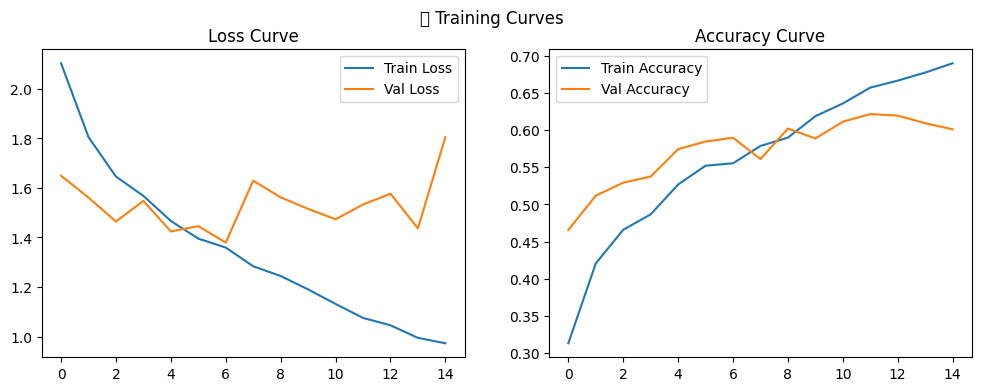

31/31 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step

🧪 Test Evaluation:
Accuracy:  0.6256
Precision: 0.6329
Recall:    0.6256
F1 Score:  0.6201


In [8]:
cnn_notuning= define_model()

# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose


🔧 Starting new training with EfficientNetB0 base (input: 224x224)...
Epoch 1/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 545s 916ms/step - accuracy: 0.2294 - loss: 2.7618 - val_accuracy: 0.4779 - val_loss: 2.0144
Epoch 2/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 566s 924ms/step - accuracy: 0.4026 - loss: 2.1847 - val_accuracy: 0.5364 - val_loss: 1.7575
Epoch 3/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 559s 919ms/step - accuracy: 0.4947 - loss: 1.9016 - val_accuracy: 0.5497 - val_loss: 1.6891
Epoch 4/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 540s 880ms/step - accuracy: 0.5230 - loss: 1.7399 - val_accuracy: 0.5579 - val_loss: 1.7142
Epoch 5/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 525s 921ms/step - accuracy: 0.5520 - loss: 1.6500 - val_accuracy: 0.5723 - val_loss: 1.6631
Epoch 6/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 510s 895ms/step - accuracy: 0.5651 - loss: 1.5747 - val_accuracy: 0.5703 - val_loss: 1.6688
Epoch 7/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 558s 889ms/step - accuracy: 0.5818 - loss: 1.4758 - val_accuracy: 0.6021 - val_loss: 1.5756
Epoch 

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


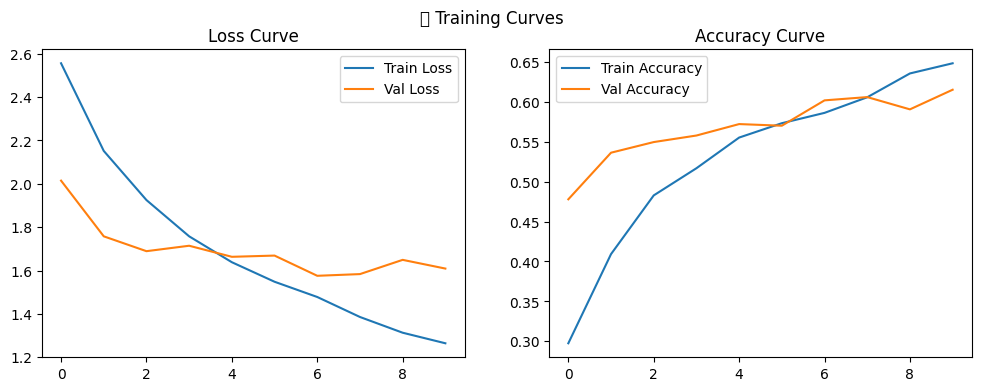

31/31 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step

🧪 Test Evaluation:
Accuracy:  0.6154
Precision: 0.6261
Recall:    0.6154
F1 Score:  0.6144


In [9]:
#TODO:
model_2 =define_model(
    optimizer_name='adam',
    learning_rate=0.0005,
    regularizer='l2',
    reg_strength=0.002,
    dropout_rate=0.6,
    use_early_stopping=True,
    batch_size=8,
    epochs=15
)



🔧 Starting new training with ResNet50 base...
Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.1065 - loss: 6.4364 - val_accuracy: 0.2318 - val_loss: 5.5834
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 406s 2s/step - accuracy: 0.2115 - loss: 5.5638 - val_accuracy: 0.2974 - val_loss: 5.1645
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 357s 2s/step - accuracy: 0.2625 - loss: 5.1577 - val_accuracy: 0.3333 - val_loss: 4.7819
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 406s 2s/step - accuracy: 0.3215 - loss: 4.7698 - val_accuracy: 0.3590 - val_loss: 4.4873
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.3522 - loss: 4.4764 - val_accuracy: 0.3959 - val_loss: 4.2588
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 339s 2s/step - accuracy: 0.3638 - loss: 4.2479 - val_accuracy: 0.3979 - val_loss: 4.0919
Epoch 7/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 401s 3s/step - accuracy: 0.3742 - loss: 4.0957 - val_accuracy: 0.4051 - val_loss: 3.9527
Epoch 8/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/st

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


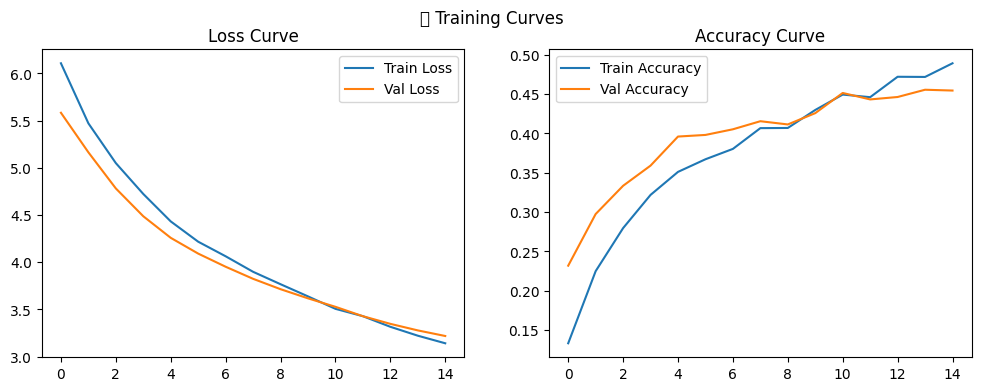

31/31 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step

🧪 Test Evaluation:
Accuracy:  0.4646
Precision: 0.4612
Recall:    0.4646
F1 Score:  0.4554


In [ ]:
#TODO:
model_3 = define_model(
    optimizer_name="rmsprop",
    learning_rate=1e-4,
    regularizer="l1",
    reg_strength=0.0005,
    dropout_rate=0.4,
    use_early_stopping=True,
    epochs=15,
    batch_size=32
)

Saving all models in the folder saved_models

In [10]:
def save_model_with_joblib(model_obj, model_name, save_dir="saved_models"):
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"{model_name}.pkl")
    joblib.dump(model_obj, save_path)
    print(f"✅ {model_name} saved to: {save_path}")


In [11]:
models = [
    ("model_1", cnn_notuning),
    ("model_2", model_2),

]

for name, model_obj in models:
    save_model_with_joblib(model_obj, name)


✅ model_1 saved to: saved_models/model_1.pkl
✅ model_2 saved to: saved_models/model_2.pkl


In [12]:
!zip -r saved_models.zip saved_models


  adding: saved_models/ (stored 0%)
  adding: saved_models/model_2.pkl (deflated 10%)
  adding: saved_models/model_1.pkl (deflated 10%)


In [15]:
from google.colab import files
files.download("saved_models.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Defining class labels

In [ ]:
class_names = [
    "Primitivism", "Japanese_Art", "Romanticism", "Baroque",
    "Academic_Art", "Western_Medieval", "Symbolism", "Art_Nouveau",
    "Realism", "Rococo", "Expressionism", "Renaissance", "Neoclassicism"
]


Evaluation function

In [ ]:
def evaluate_model(model_obj, model_name):
    y_probs = model_obj["model"].predict(X_test)
    y_preds = np.argmax(y_probs, axis=1)

    cm = confusion_matrix(y_test, y_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    plt.figure(figsize=(12, 10))
    disp.plot(xticks_rotation=45, cmap="Blues", values_format="d")
    plt.title(f"📊 Confusion Matrix - {model_name}")
    plt.grid(False)
    plt.tight_layout()
    plt.show()
    f1 = f1_score(y_test, y_preds, average='macro')
    print(f"🧪 F1 Score for {model_name}: {f1:.4f}")



📊 Evaluating model_1...
31/31 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step


<ipython-input-55-958599518>:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1200x1000 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


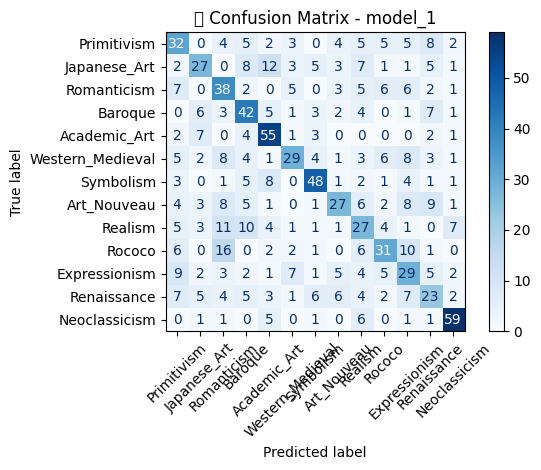

🧪 F1 Score for model_1: 0.4752

📊 Evaluating model_2...
31/31 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step


<ipython-input-55-958599518>:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1200x1000 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


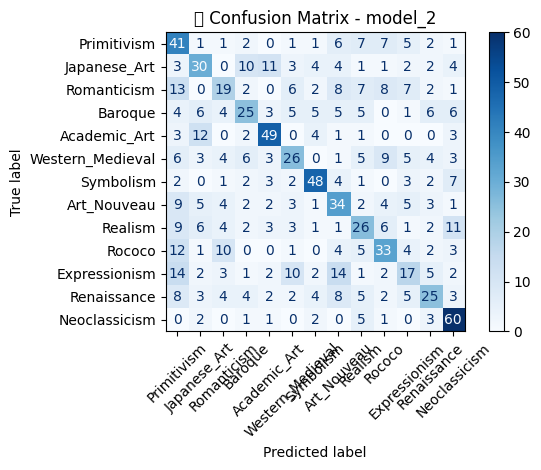

🧪 F1 Score for model_2: 0.4361

📊 Evaluating model_3...
31/31 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step


<ipython-input-55-958599518>:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1200x1000 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


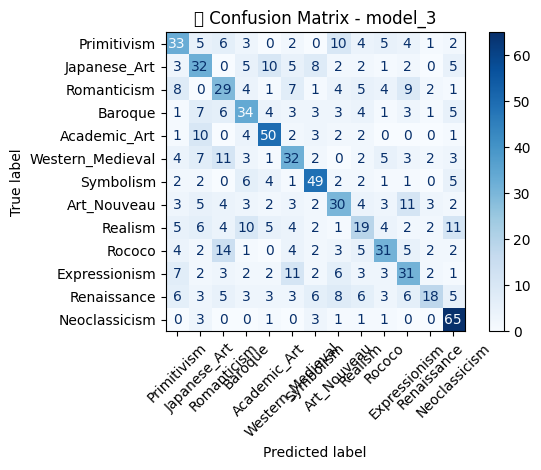

🧪 F1 Score for model_3: 0.4554


In [ ]:
# Loop to evaluate and show confusion matrices
for name, model_dict in models:
    print(f"\n📊 Evaluating {name}...")
    evaluate_model(model_dict, name)


Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [ ]:
def make_predictions(model_path, X):

    model_dict = joblib.load(model_path)
    model = model_dict["model"]

    probas = model.predict(X)
    predictions = np.argmax(probas, axis=1)

    return predictions

In [ ]:
X_sample = X_test
preds = make_predictions("saved_models/model_1.pkl", X_sample)
print(preds[:10])

31/31 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step
[ 0  2 12  8 12 12 11  6  4 10]


Congratulations!!
